In [1]:
from MyFunctions import *

# Fire calls to the San Francisco Fire Department (SFFD)

This project generates a model to forecast the next day number of non-medical calls to the San Francisco Fire Department, allowing the Department to get ready with the necessary resources and personnel to take care of the calls.

The calls could be related to fire, rescues, biological-hazards, explotions, industrial accidents, etc. 

Information comes from different sources:
- __Calls to SFFD:__ More than 500k records with details about every call since 2003 ([DataSF](https://data.sfgov.org/Public-Safety/Fire-Incidents/wr8u-xric) : Downloaded in July 28th 2019).
- __Weather conditions:__ [NOAA](https://www.ncdc.noaa.gov/cdo-web/)
    - Daily information for precipitation, minimum and maximum temperature from SF downtown station
    - Daily information for: average wind and gusts (2mins and 5 secs) from SF airport
 
Data from the calls to the SFFD was aggregated by day and merged with weather data. Creation of the time series model involved __feature engineering__ like:
- __RainxGusts =__ (precipitation x gust at 5 seconds)<sup>2</sup>
- __Moving holidays__ such as thanks giving

The project was developped in Python 3 using libraries such as: Pandas, Sklearn and ipywidgets

## Use this tool to forecast the number of calls to the San Francisco Fire Department:

Please enter your weather forecast using the boxes provided below, and hit the orange button to get the forecast. The last available day in our system is displayed. Forecast for the following day will be computed.

Note: To get another forecast for a different weather input, run the following cell again and then hit the forecast button.

Last available day in our database:  2019-06-30
Please enter weather forecast for  2019-07-01 : 


Your input:
Date: 2019-07-01 AWND: [12.75] WSF5: [29.1] PRCP: [0.0] TMIN: [54.0] TMAX: [64.0]



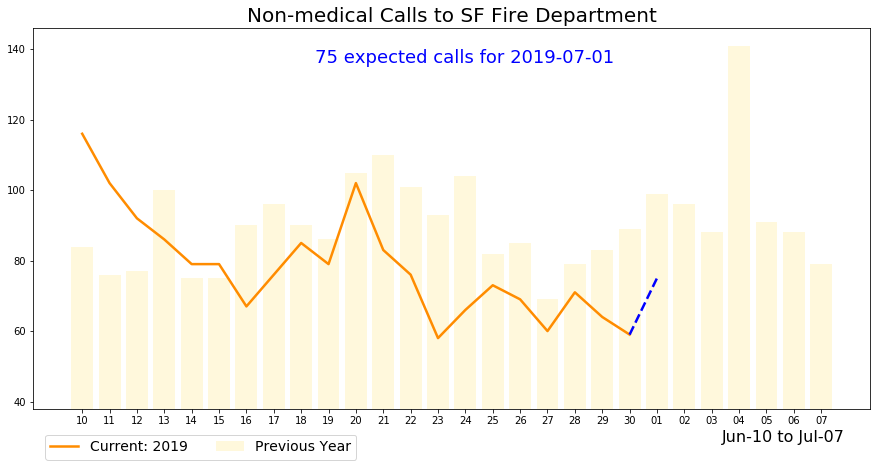

In [2]:
display_form()

## Performance of the model
#### Data
- Trainig data: Jan 1st, 2003 to Dec 31st, 2016
- Validation data: Jan 1st, 2017 to Jun 30th, 2019

In [10]:
DF = read_data2()
DF_complete, indeps = add_features(DF)
model, train, test = final_model(DF_complete)

#### Naive model
Using the calls of the previous day to forecast the number of calls will provide us with a base model to compare the performance of the final model. Mean square error (MSE) is 391, and R2 score is negative (-0.38). Run the cell, and see the results for yourself.

In [11]:
print('MSE Naive prev day= ', round(sklearn.metrics.mean_squared_error(test['Calls'], test['Calls_last_1d'])))
print('R2 Naive prev day= ',round(sklearn.metrics.r2_score(test['Calls'], test['Calls_last_1d']),2))

MSE Naive prev day=  391.0
R2 Naive prev day=  -0.38


#### Final model
Different linear and non-linear models were tested including Random Forest and Ridge Linear Regression but all of them arrived to a similar score. The final model uses Linear Regression with an R2 score of 0.29 reducing the MSE error, from 391 with the naive model, to 200. 

As a first step, Fourier analysis was used finding relevants cycles for: year, semester, quarters , months and weeks. Values for Fourier were included as part of the features in the final model which considers 54 variables including as well: the engineered featured of (precipitation x gusts at 5 secs)<sup>2</sup>, average wind, maximum temperature for the day, minimum temperature of the day, a smoothed value from the previous week (minimum between the calls from the previous week -same day- and 2 weeks before), volume of calls from the previous day, average from the previous year and 4 weeks moving average. In addition to those variables, it also uses indicator variables for: thanksgiving, black friday, weekday (Monday to Thursday), weekend (Friday and Saturday), Sunday and month.

Although there is room for improvement, the final model follows well the trend and is able to predict some of the edge values. Some more feature engineering can be done given more time (including many relevant missing holidays and important dates like school calendar). Modeling noise might also be considered.

Run the following cell to see how forecasted values (orange) follow the original values (blue) for the volume of calls to SFFD:

Note: A model with almost the same performance an only 12 variables can also be seen under the section "Additional information for the curious ones: An heuristic approach"

MSE final model:  200.0
R2 final model:  0.29


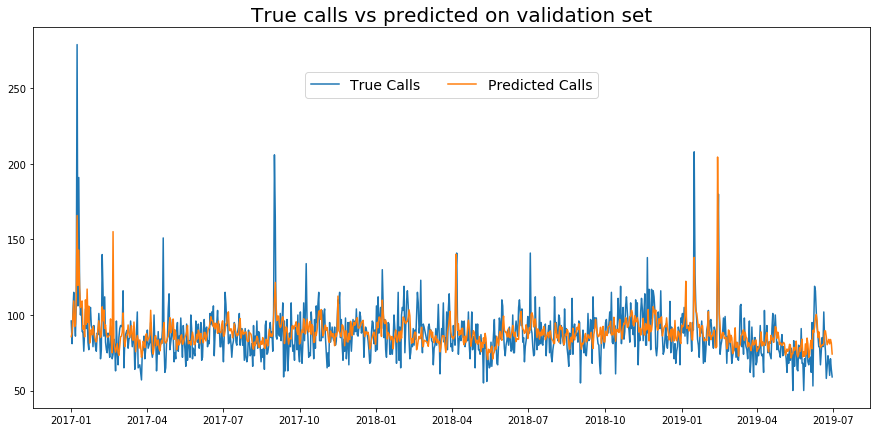

In [12]:
predicted = model.predict(X=test.drop(['Calls'],axis=1))
metrics2('Test',test, 'Calls', predicted)

#### Scores
A normalized version of the model is below allowing a fair comparisons of the coefficients. If you want to see the coefficients, run the next 3 cells:

In [13]:
model_normalized = sklearn.linear_model.LinearRegression(normalize=True).fit(
        X=train.drop(['Calls'],axis=1), y=train['Calls'])

In [14]:
indeps = set(test.columns)
indeps.remove('Calls')
coef_li = [(feat, round(coef,2)) for feat, coef in zip(list(indeps),model_normalized.coef_)]

If you want to take a peek, these are the coeficients in descending order of importance:

In [15]:
def sortSec(val): 
    return abs(val[1]) 
  
# sort descending by 2nd element
coef_li.sort(key = sortSec, reverse = True) 
print(coef_li) 

[('smoothed_prev_week', -22600867069640.6), ('Friday', 7210144316896.69), ('Dec', 7210144316895.62), ('cos(day)', 7210144316893.81), ('Aug', 7210144316892.6), ('prev_year', 7210144316890.41), ('Apr', 7210144316890.24), ('Tuesday', 7210144316890.18), ('AWND', 7210144316886.96), ('Oct', 7210144316882.29), ('Wednesday', 7210144316881.68), ('TMAX', 7210144316878.42), ('sin(mo)', 7210144316877.63), ('Feb', 4964718933213.29), ('Jun', 4962608159819.28), ('Julian', -2968035486585.28), ('sin(Qs)', 2482575023580.19), ('diff7_MA3m_7d', 1991672421373.57), ('sin(year)', -1069353821876.93), ('cos(year)', -492408383720.13), ('Thursday', -491385810701.72), ('year_avg_1d', -488604901490.4), ('Weekend_FS', -486159737441.55), ('prev_1wk', 3159189166.83), ('diff1_smoothed_prev_week', -1178395184.31), ('WSF5', -109438229.9), ('cos(mo)', -15.23), ('prev_2wk', -9.54), ('TMIN', 8.44), ('const', -7.76), ('Sep', -3.86), ('Sunday', 3.19), ('Saturday', 1.87), ('PRCP', -0.88), ('May', -0.71), ('RainxGusts', -0.7),

## Additional information for the curious ones
### An heuristic approach
By taking some of the most relevant features, it is possible to achieve almost the same performance with only 12 features (MSE=205, R2=0.28). These are: the engineered featured of (precipitation x gusts at 5 secs)<sup>2</sup>, maximum temperature for the day, a smoothed value from the previous week (minimum between the calls from the previous week -same day- and 2 weeks before), volume of calls from the previous day and average from the previous year. In addition to those variables, it also uses indicator variables for: thanksgiving, black friday, weekday (Monday to Thursday), weekend (Friday and Saturday), Sunday and the month of January. Run the next cell to see the performance of this simpler model:

MSE final model:  205.0
R2 final model:  0.28


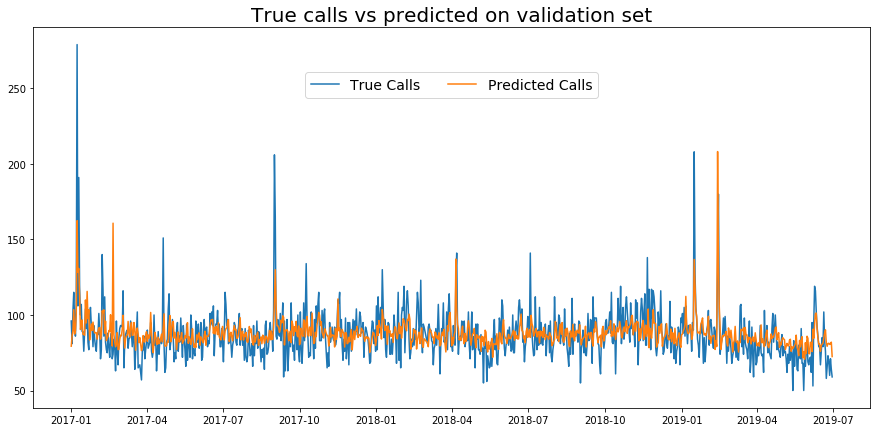

In [16]:
myFeatures = ['RainxGusts','TMAX','smoothed_prev_week','Calls_last_1d','Thanks_Thu','Thanks_Fri','Weekday_MT',\
             'Weekend_FS','prev_year','Sunday','year_avg_1d','Jan']
my_lr_model = sklearn.linear_model.LinearRegression().fit(
        X=train[myFeatures], y=train['Calls'])
my_lr_predicted = my_lr_model.predict(X=test[myFeatures])
metrics2('Test',test, 'Calls', my_lr_predicted)

In [ ]:
my_model_normalized = sklearn.linear_model.LinearRegression(normalize=True).fit(
        X=train[myFeatures], y=train['Calls'])

### Decision trees instead of linear regression
Decision trees are a good alternative to explore non linear models. Considering that we already found 12 strong variables, a decision tree could provide us as well with a self-explanatory model. However, it does not perform well. The mean square error is larger than the one from the Naive model.

MSE final model:  393.0
R2 final model:  -0.39


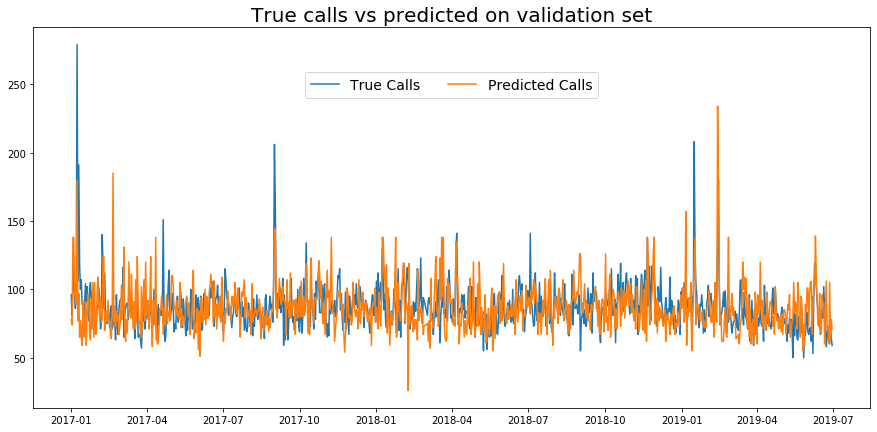

In [22]:
my_tree_model = sklearn.tree.DecisionTreeRegressor(random_state=0).fit(X=train[myFeatures], y=train['Calls'])
my_tree_predicted = my_tree_model.predict(X=test[myFeatures])
metrics2('Test',test, 'Calls', my_tree_predicted)

 ### Random forest instead of linear regression
Random forest achieved almost the same performance than linear regression. In addition to that, the final model is less intuitive. You can see the results by running the cell.

MSE final model:  220.0
R2 final model:  0.22


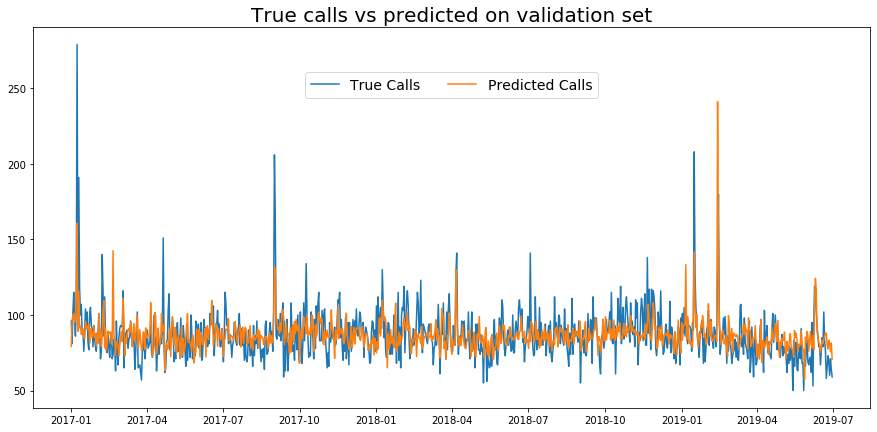

In [18]:

my_forest_model= sklearn.ensemble.RandomForestRegressor(n_estimators=20, max_depth=200, random_state = 0).fit(X=train[myFeatures], y=train['Calls'])
my_forest_predicted = my_forest_model.predict(X=test[myFeatures])
metrics2('Test',test, 'Calls', my_forest_predicted)